In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
class FiringRateModel(torch.nn.Module):
    def __init__(
        self, 
        g, # activation function
        k: int = 0 # number of previous timesteps for current I
    ):
        super().__init__()
        self.g = g
        self.a = torch.nn.Parameter(torch.zeros(k))
        self.b = torch.nn.Parameter(torch.randn(1)[0])
        self.k = k
        
    def forward(
        self,
        currents, # currents tensor, size k+1
        prev_f # previous firing rate
    ):
        if self.k > 0:
            x = currents[:-1] @ F.sigmoid(self.a)
            return self.g(currents[-1] + x - self.b * prev_f)
        else:
            return self.g(currents[0] - self.b * prev_f)

In [3]:
# placeholder for data
Is = torch.randn(1000)
fs = torch.randn(1000)

train_ratio = 0.7
train_size = int(len(Is) * train_ratio)
Is_tr = Is[:train_size]
fs_tr = fs[:train_size]
Is_te = Is[train_size:]
fs_te = fs[train_size:]

In [4]:
def train_model(
    model,
    criterion,
    optimizer,
    Is_tr,
    fs_tr,
    k: int,
    epochs: int = 10,
    print_every: int = 10
):
    for epoch in range(epochs):
        f = fs_tr[0] # initialize firing rate to t=0
        loss = 0
        n = 0
        for i in range(k+1, len(Is_tr)):
            currs = Is_tr[i-k:i+1]
            f = model(currs, f)
            loss += criterion(f, fs_tr[i])
            n += 1

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1) # prevent gradient explosion
        optimizer.step()

        if (epoch+1) % print_every == 0:
            print(f"Epoch {epoch+1} / Loss: {loss.item() / n}")
            
def test_model(model, criterion, Is, fs, k: int):
    with torch.no_grad():
        f = fs[0] # initialize firing rate to t=0
        loss = 0
        n = 0
        for i in range(k+1, len(Is)):
            currs = Is[i-k:i+1]
            f = model(currs, f)
            loss += criterion(f, fs[i]).item()
            n += 1
    return loss / n

def predict(model, Is, fs, k: int):
    with torch.no_grad():
        f = fs[0] # initialize firing rate to t=0
        pred_fs = []
        for i in range(k+1, len(Is)):
            currs = Is[i-k:i+1]
            f = model(currs, f)
            pred_fs.append(f)
    return pred_fs

def plot_predictions(model, Is, fs, k: int):
    pred_fs = predict(model, Is, fs, k)
    ts = list(range(1, len(fs)))
    plt.plot(ts, fs[1:], label="Actual")
    plt.plot(ts, pred_fs, label="Predicted")
    plt.legend()
    plt.ylabel("Firing rate")
    plt.xlabel("t")

In [5]:
k = 0
# model with placeholder activation function
model = FiringRateModel(F.sigmoid, k=k)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

train_model(
    model, 
    criterion, 
    optimizer,
    Is_tr,
    fs_tr,
    k,
    epochs = 10,
    print_every = 1
)

train_loss = test_model(
    model, 
    criterion, 
    Is_tr,
    fs_tr,
    k
)

test_loss = test_model(
    model, 
    criterion, 
    Is_te,
    fs_te,
    k
)

print(f"\nTrain Loss: {train_loss}")
print(f"Test Loss: {test_loss}")

Epoch 1 / Loss: 1.1897135067395386
Epoch 2 / Loss: 1.1799156614639217
Epoch 3 / Loss: 1.1707200471935355
Epoch 4 / Loss: 1.162104048612974
Epoch 5 / Loss: 1.1540394620663448
Epoch 6 / Loss: 1.146502537106581
Epoch 7 / Loss: 1.1394639349461284
Epoch 8 / Loss: 1.1328993812309995
Epoch 9 / Loss: 1.1267838157468257
Epoch 10 / Loss: 1.1210878997060534

Train Loss: 1.1157892112037062
Test Loss: 1.1894753595278535


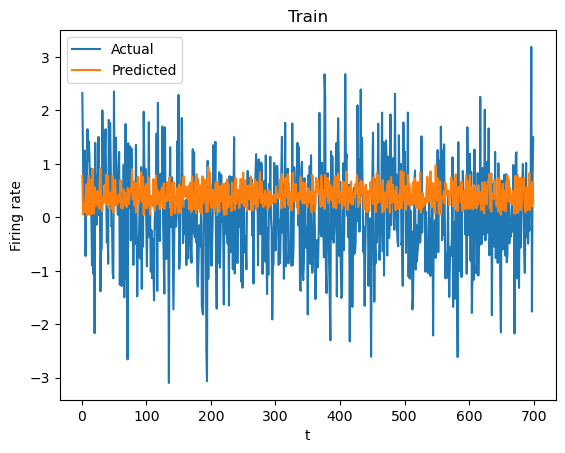

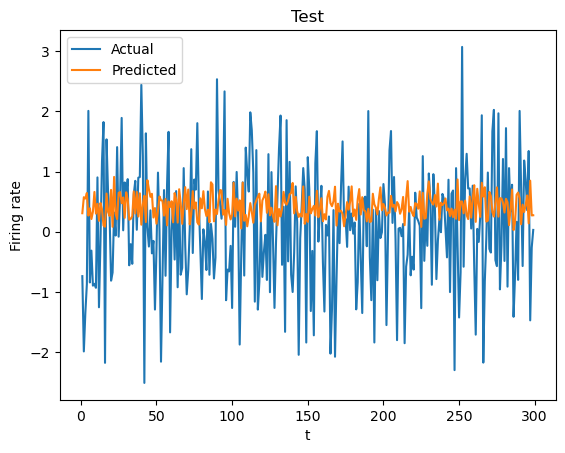

In [6]:
plt.figure()
plot_predictions(model, Is_tr, fs_tr, k)
plt.title("Train")

plt.figure()
plot_predictions(model, Is_te, fs_te, k)
plt.title("Test");